# Homework 7: Classification

This homework assignment is designed to give you practice with classification models. We'll try to predict which words are more likely to be responded to correctly during a lexical decision task, based on their length and frequency.

We will be using data from the English Lexicon Project again. However, this time we will use response correctness as our dependent variable. Load **LexicalData_withIncorrect.csv**, which includes incorrect trials as well as correct ones, and also **Items.csv**. Both can be found in the *Homework/lexDat* folder in the class GitHub repository. 

This data is a subset of the [English Lexicon Project database](https://elexicon.wustl.edu/). It provides response correctness and reaction times (in milliseconds) of many subjects as they are presented with letter strings and asked to decide, as quickly and as accurately as possible, whether the letter string is a word or not. The **Items.csv** provides characteristics of the words used, namely frequency (how common is this word?) and length (how many letters?). 

*Data courtesy of Balota, D.A., Yap, M.J., Cortese, M.J., Hutchison, K.A., Kessler, B., Loftis, B., Neely, J.H., Nelson, D.L., Simpson, G.B., & Treiman, R. (2007). The English Lexicon Project. Behavior Research Methods, 39, 445-459.*

---
## 1. Loading and formatting the data (1 point)

Load in data from the **LexicalData_withIncorrect.csv** and **Items.csv** files. Use `left_join` to add word characteristics `Length` and `Log_Freq_Hal` from **Items** to the **LexicalData**, and use `drop_na()` to get rid of any observations with missing values. Then use `head()` to look at the first few rows of the data. 

*Note: We're just working with `Correct` in this homework, so no need to worry about reformatting reaction times.*

In [2]:
library(tidyverse)

lexical <- read.csv("LexicalData_withIncorrect.csv")
items <- read.csv("Items.csv")

items.small <- items %>% mutate(D_Word = Word) %>% select(D_Word, Length, Log_Freq_HAL)

data <- left_join(items.small, lexical, by = "D_Word") %>% drop_na()

head(data)


,D_Word,Length,Log_Freq_HAL,X,Sub_ID,Trial,Type,D_RT,Outlier,D_Zscore,Correct
,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>
1,synergistic,11,5.649,9098,148,449,1,776,false,0.125,1
2,synergistic,11,5.649,67239,224,194,1,710,false,-0.030,0
3,synonymous,10,6.858,28980,20,146,1,"1,525",false,1.235,1
4,synonymous,10,6.858,72883,280,146,1,"1,042",false,0.633,0
5,syntactical,11,4.736,974,162,47,1,"1,365",false,1.768,1
6,synthesis,9,8.816,10385,155,93,1,759,false,0.745,1


---
## 2. Visualizing the data (1 point)

First, we'll try to visualize whether trials that are responded to correctly versus incorrectly differ from each other in terms of word length and log frequency. The code is included below, so that this homework doesn't get too cumbersome. All you have to do is **change the name of the data set**, **run the code**, and **write some observations about the output**.

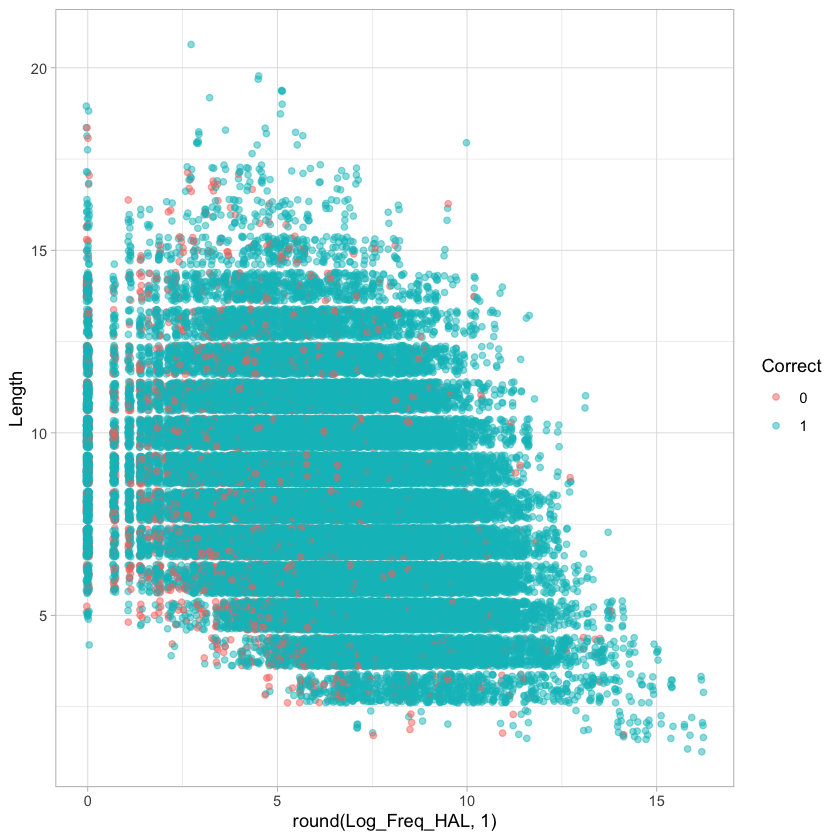

In [3]:
library(tidyverse) # Load the tidyverse package, if you haven't yet
data$Correct <- as.factor(data$Correct) # so that R knows that Correct is categorical, not numeric. 

# plot the Correct / Incorrect clusters
ggplot(data,aes(x=round(Log_Freq_HAL,1),y=Length,col=Correct)) + geom_point(position="jitter",alpha=0.5) + theme_light() 


What do you observe about the "Correct" and "Incorrect" clusters? 

> *There are fewer "correct clusters" than "incorrect" clusters. Likewise, it appears that words used less frequently fall more into "incorrect" clusters than words used more frequently. There does not visually appear to be a difference in clustering by length of word.* 
> 

---
## 3. Logistic Regression: Fitting the model (2 points)

Fit a logistic regression model to the data using `Length`, `Log_Freq_HAL`, and their interaction to predict `Correct`. Use `glm()` to fit the model, and look at its output using `summary()`.

In [5]:
glm.fit = glm(Correct~Length+Log_Freq_HAL+Length*Log_Freq_HAL, data=data, family=binomial) # logistic regression 
summary(glm.fit)


Call:
glm(formula = Correct ~ Length + Log_Freq_HAL + Length * Log_Freq_HAL, 
    family = binomial, data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.0494   0.3178   0.4182   0.5208   1.3225  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.939996   0.115623  -8.130 4.30e-16 ***
Length               0.151266   0.012789  11.828  < 2e-16 ***
Log_Freq_HAL         0.394772   0.018762  21.041  < 2e-16 ***
Length:Log_Freq_HAL -0.010558   0.002202  -4.795 1.63e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 49809  on 70588  degrees of freedom
Residual deviance: 46563  on 70585  degrees of freedom
AIC: 46571

Number of Fisher Scoring iterations: 5


What can you conclude from this output? (a brief gist is fine)

> *This logistic regression model demonstrates that there is a significant effect of length and of word use frequency on whether people responded correctly versus incorrectly. There is also a significant interaction between word use frequency and length of word on correctness classification.* 
> 

---
## 4. Interpreting predictions from the model (3 points)

Finally, look at how well this logistic regression model does at predicting correctness. Use `predict()` and a threshold of 0.5 to generate predicted `Correct` values for each trial, then output a confusion matrix and overall accuracy for these predictions.

*Hint: see the Classifiers tutorial.*

In [6]:
predictdata = data.frame(predict(glm.fit, type = "response"))
colnames(predictdata) = c('predicted_prob')

num_observations = nrow(predictdata)
predictdata$index = seq(1, num_observations) 

threshold = 0.50 #binarizing threshold

# First make a list of "0" (incorrect values)
predictdata$predicted_binary=rep("0", num_observations)

# Then use the probability output to label the correct values/1. Let's use a threshold of 50% probability. 
predictdata$predicted_binary[predictdata$predicted_prob>threshold]="1" #find the rows that have prob > threshold and cast as '1'

# Now let's look at the prediction accuracy
confusion_df = data.frame(predictdata$predicted_binary, data$Correct)
colnames(confusion_df) = c('predicted', 'actual')

table(confusion_df)

print(paste("Accuracy:",mean(confusion_df$predicted == confusion_df$actual)))


         actual
predicted     0     1
        0    13    44
        1  7966 62566

[1] "Accuracy: 0.886526229299183"


Did the model do well at predicting lexical decision correctness? Why or why not? 

> The model does a decently well job at predicting lexical decision correctness. The confusion matrix demonstrates the frequency of the correct predictions and the errors. From these values we computed the accuracy of the model. In this case, the model is correct ~89% of the time in estimating lexical decision correctness  

## 5. QDA (3 points)

Load in the `MASS` library and fit a QDA model to the data set. The predictors are still `Length`, `Log_Freq_HAL`, and their interaction, just like the logistic regression model you just ran, and the dependent variable is still `Correct`. 

*Hint: see the Classifiers tutorial.*

In [8]:
library(MASS)
qda.fit = qda(Correct~Length + Log_Freq_HAL + Length*Log_Freq_HAL, data=data)
qda.fit

Call:
qda(Correct ~ Length + Log_Freq_HAL + Length * Log_Freq_HAL, 
    data = data)

Prior probabilities of groups:
        0         1 
0.1130346 0.8869654 

Group means:
    Length Log_Freq_HAL Length:Log_Freq_HAL
0 8.047124     4.932123            37.95260
1 7.979971     6.444849            49.34219

Now look at how well the predicted `Correct` values compare with actual `Correct` values for the whole data set. Output a confusion matrix and overall prediction accuracy. 

In [9]:
# predicting LDA coefficients
qda.pred=predict(qda.fit, data)

# Extracting  output of the prediction 
qda.class = qda.pred$class
table(qda.class, data$Correct)
print(paste("Accuracy:",mean(qda.class==data$Correct)))


         
qda.class     0     1
        0   455  1647
        1  7524 60963

[1] "Accuracy: 0.870078907478502"


How does QDA prediction performance differ from that of logistic regression?

> The accuracy of the QDA prediction is very similar, but a little lower, to that of the logistic regression. The QDA model is correct ~87% of the time in estimating lexical decision correctness

**DUE:** 5pm EST, March 25, 2022

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here. 
> *Delainey Wescott*